In [8]:
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import v2
# from torchvision.transforms.v2 import ToTensor


import matplotlib
import matplotlib.pyplot as plt

# matplotlib.use('agg')  # Set the backend to 'agg'


print(torch.__version__)
print("torchvision.__version__")

2.5.1
torchvision.__version__


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:

train_fashionMNIST_data = torchvision.datasets.FashionMNIST(root="data",
                                                            download=True,
                                                            transform=v2.Compose(
                                                                [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                                            train=True,
                                                            target_transform=None)

test_fashionMNIST_data = torchvision.datasets.FashionMNIST(root="data",
                                                           download=True,
                                                           transform=v2.Compose(
                                                               [v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                                           train=False,
                                                           target_transform=None)


In [12]:
train_fashionMNIST_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

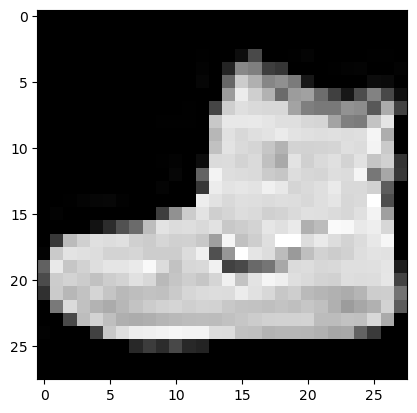

In [13]:
image, label = train_fashionMNIST_data[0]

plot = plt.imshow(image.squeeze(), cmap='gray')
plt.show()

# plt.plot([1, 2, 3], [4, 5, 6])
# plt.title("Test Plot")
# plt.show()


In [14]:
class_names = train_fashionMNIST_data.class_to_idx
class_names

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

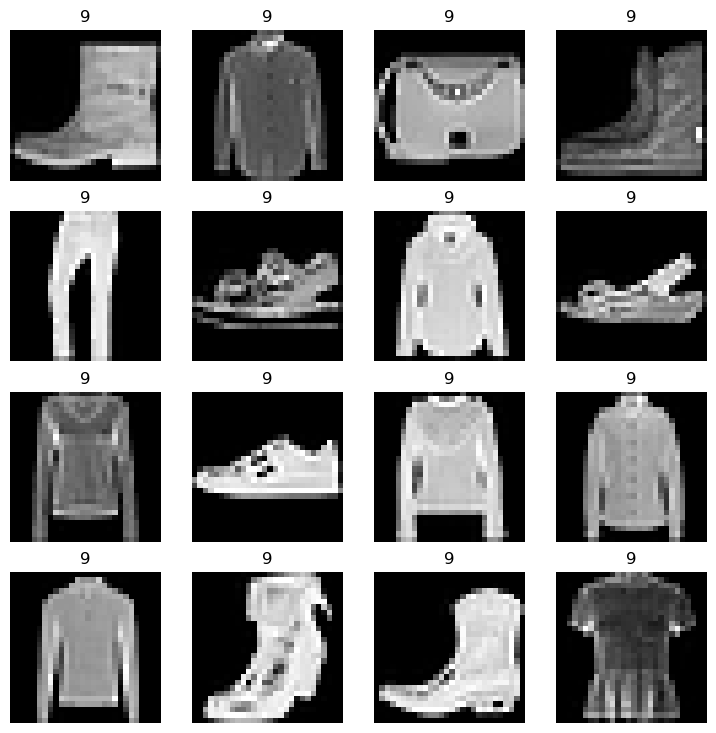

In [15]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))

rows, cols = 4, 4

for i in range(16):
    random_idx = torch.randint(0, len(train_fashionMNIST_data), size=(1,)).item()
    # print(random_idx)
    image = train_fashionMNIST_data[random_idx][0]
    fig.add_subplot(rows, cols, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')

    plt.title(label)
    plt.axis('off')

In [16]:
train_fashionMNIST_data
test_fashionMNIST_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
                 ToImage()
                 ToDtype(scale=True)
           )

# 2 Prepare DataLoader

From torch Datasets but we want to have in python itterable.

We need to break Batch into mini batches.

In [17]:
train_dataloader = DataLoader(dataset=train_fashionMNIST_data,
                              batch_size=32,  #Comman Batch Size, It can vary
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_fashionMNIST_data,
                             batch_size=32,
                             shuffle=False)


In [18]:
len(test_dataloader)

313

In [19]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

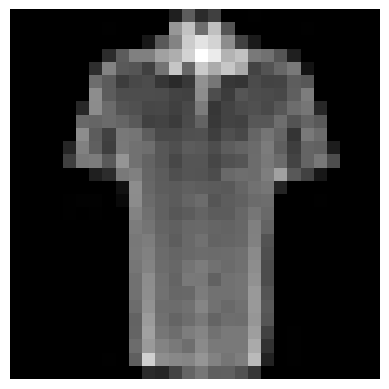

In [20]:
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')
plt.show()


# Creating a Basline Model

We will improve with future models as we go.

In [21]:
# Create a Flatten Layer
flatten_model = nn.Flatten()

# data
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x)

print(f"shape before flatten: {x.shape}")
print(f"shape after flatten: {output.shape}")

shape before flatten: torch.Size([1, 28, 28])
shape after flatten: torch.Size([1, 784])


In [22]:
class FashionMNISTv0(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_units,
                 output_size):
        super().__init__()

        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_size, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_size),
        )

    def forward(self, x):
        return self.layers(x)

In [23]:
torch.manual_seed(42)

model_0 = FashionMNISTv0(input_size=784, hidden_units=10, output_size=len(class_names))
model_0.to(device)

FashionMNISTv0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [24]:
dummy_x = torch.rand(1, 1, 28, 28)
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [25]:
model_0.state_dict()

OrderedDict([('layers.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layers.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layers.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.3130, -0.0118,


In [26]:
from helper_functions import *

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=model_0.parameters(), lr=0.1)



In [27]:
print(train_dataloader)


# Creating A function to Time our Operations

How fast it runs and Models Peformance(Loss and Accuracy)


In [28]:
from timeit import default_timer as timer
from tqdm.auto import tqdm


def print_train_time(start, end, device: torch.device = None):
    """ Prints Difference Start and End """

    total_time = end - start
    print(f"Total time: {total_time} seconds")
    return total_time

In [29]:
# Training on Batches of 32
torch.manual_seed(42)

start_time = timer()

""" Loop, calculate train - Test loss per batch, """

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----------")

    train_loss = 0

    # Add a loop to loop through the training batches
    for batch, (x, y) in enumerate(train_dataloader):
        model_0.train()

        y_pred = model_0(x)

        loss = loss_fn(y_pred, y)

        train_loss += loss  # accumulate train loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} Samples")

    # Divide total loss by len of dataloder

    train_loss = train_loss / len(train_dataloader)
    # print(f"Train loss: {train_loss}")

    # Testing
    test_loss, test_acc = 0, 0

    model_0.eval()

    with torch.inference_mode():
        for batch, (x_test, y_test) in enumerate(test_dataloader):
            test_pred = model_0(x_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(y_pred=test_pred.argmax(dim=1), y_true=y_test)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)
    print(f"Train Loss: {train_loss} Test loss: {test_loss} Test accuracy: {test_acc}")

end_time = timer()

print_train_time(start_time, end_time, device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.5903892517089844 Test loss: 0.5095350742340088 Test accuracy: 82.03873801916933
Epoch: 1 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.476331889629364 Test loss: 0.47989004850387573 Test accuracy: 83.19688498402556
Epoch: 2 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.4550333023071289 Test loss: 0.47663894295692444 Test accuracy: 83.42651757188499
Total time: 24.60644450000109 seconds


24.60644450000109

# Make Predictions and get Model0 results

In [30]:
torch.manual_seed(42)


def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            # Make Pred

            y_pred = model(x)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y)
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model": model.__class__.__name__, "test_loss": loss.item(), "test_accuracy": acc}


#Calculate Model 0 results on test datasets

model_0_result = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn)

model_0_result


  0%|          | 0/313 [00:00<?, ?it/s]

{'model': 'FashionMNISTv0',
 'test_loss': 0.47663894295692444,
 'test_accuracy': 83.42651757188499}

In [31]:
class FashionMNISTv1(nn.Module):
    def __init__(self,
                 input_size,
                 hidden_units,
                 output_size):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_size, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_size),

        )

    def forward(self, x):
        return self.layers(x)


model_1 = FashionMNISTv1(input_size=784, hidden_units=10, output_size=len(class_names))
model_1.to(device)



FashionMNISTv1(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
    (5): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [32]:
loss = nn.CrossEntropyLoss()

optimizer = optim.SGD(params=model_1.parameters(), lr=0.01)

In [33]:
# Training on Batches of 32
torch.manual_seed(42)

start_time = timer()

""" Loop, calculate train - Test loss per batch, """

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----------")

    train_loss = 0

    # Add a loop to loop through the training batches
    for batch, (x, y) in enumerate(train_dataloader):
        model_1.train()

        y_pred = model_1(x)

        loss = loss_fn(y_pred, y)

        train_loss += loss  # accumulate train loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} Samples")

    # Divide total loss by len of dataloder

    train_loss = train_loss / len(train_dataloader)
    # print(f"Train loss: {train_loss}")

    # Testing
    test_loss, test_acc = 0, 0

    model_0.eval()

    with torch.inference_mode():
        for batch, (x_test, y_test) in enumerate(test_dataloader):
            test_pred = model_1(x_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(y_pred=test_pred.argmax(dim=1), y_true=y_test)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)
    print(f"Train Loss: {train_loss} Test loss: {test_loss} Test accuracy: {test_acc}")

end_time = timer()

print_train_time(start_time, end_time, device=str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 1.2675429582595825 Test loss: 0.7684377431869507 Test accuracy: 71.67531948881789
Epoch: 1 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.6527134776115417 Test loss: 0.6070497632026672 Test accuracy: 78.78394568690096
Epoch: 2 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.5601860880851746 Test loss: 0.5590938329696655 Test accuracy: 80.37140575079871
Total time: 27.74128909999854 seconds


27.74128909999854

In [34]:
# Get Model1 Dictionary
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn)

model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model': 'FashionMNISTv1',
 'test_loss': 0.5590938329696655,
 'test_accuracy': 80.37140575079871}

# BUILDING A CNN

In [35]:
# create Convolutional neural network


class FashionMNISTv2(nn.Module):
    """
    Model architecture that replicates the tinyVGG
    model form cnn explainer website
    """

    def __init__(self, input_size, hidden_units, output_size):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_size,
                      out_channels=hidden_units,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        # We had to Calculate the in_features for classifier by looking at the output shape and Errors.
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_size),

        )
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)


        return x

model_2 = FashionMNISTv2(1, 10, len(class_names))
model_2.to(device)

FashionMNISTv2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [36]:
rand_image = torch.randn(1, 1, 28, 28).to(device)

model_2(rand_image)

tensor([[-1.0238e-04, -6.5328e-04, -7.0773e-03,  4.9903e-02,  1.2112e-01,
          4.2032e-02, -7.0080e-02,  4.2303e-02, -3.0948e-04,  5.1526e-02]],
       grad_fn=<AddmmBackward0>)

In [37]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=model_2.parameters(), lr=0.1)


In [38]:
# Training on Batches of 32
torch.manual_seed(42)

start_time = timer()

""" Loop, calculate train - Test loss per batch, """

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch} \n----------")

    train_loss = 0

    # Add a loop to loop through the training batches
    for batch, (x, y) in enumerate(train_dataloader):
        model_2.train()

        y_pred = model_2(x)

        loss = loss_fn(y_pred, y)

        train_loss += loss  # accumulate train loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(x)}/{len(train_dataloader.dataset)} Samples")

    # Divide total loss by len of dataloder

    train_loss = train_loss / len(train_dataloader)

    # Testing
    test_loss, test_acc = 0, 0

    model_2.eval()

    with torch.inference_mode():
        for batch, (x_test, y_test) in enumerate(test_dataloader):
            test_pred = model_2(x_test)

            test_loss += loss_fn(test_pred, y_test)

            test_acc += accuracy_fn(y_pred=test_pred.argmax(dim=1), y_true=y_test)

        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)
    print(f"Train Loss: {train_loss} Test loss: {test_loss} Test accuracy: {test_acc}")

end_time = timer()

print_train_time(start_time, end_time, device=str(next(model_2.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.6442743539810181 Test loss: 0.3986058533191681 Test accuracy: 86.0423322683706
Epoch: 1 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.3579982817173004 Test loss: 0.35163965821266174 Test accuracy: 87.20047923322684
Epoch: 2 
----------
Looked at 0/60000 Samples
Looked at 12800/60000 Samples
Looked at 25600/60000 Samples
Looked at 38400/60000 Samples
Looked at 51200/60000 Samples
Train Loss: 0.3220406174659729 Test loss: 0.3151688873767853 Test accuracy: 88.68809904153355
Total time: 67.43882830000075 seconds


67.43882830000075

In [39]:
model_2_results = eval_model(model_2, test_dataloader, loss_fn, accuracy_fn)
model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model': 'FashionMNISTv2',
 'test_loss': 0.3151688873767853,
 'test_accuracy': 88.68809904153355}

In [40]:
model_1_results

{'model': 'FashionMNISTv1',
 'test_loss': 0.5590938329696655,
 'test_accuracy': 80.37140575079871}

Make and Evaluate Random Predictions with best model

In [ ]:
def make_predictions(model, data: list, device: torch.device=device):
    pred_prods = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            